# **Predicting interest rates from Federal Reserve documents**
## Per-sentence sentiment (Vol. 7)
FE 690: Machine Learning in Finance \\
Author: Theo Dimitrasopoulos \\
Advisor: Zachary Feinstein \\

## **Setup**

### Environment

In [1]:
# -*- coding: utf-8 -*-

# ENVIRONMENT CHECK:
import sys, os, inspect, site, pprint
# Check whether in Colab:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB == True:
  print('YES, this is a Google Colaboratory environment.')
else:
  print('NO, this is not a Google Colaboratory environment.')
print(' ')

# Python installation files:
stdlib = os.path.dirname(inspect.getfile(os))
python_version = !python --version
print('Python Standard Library is located in:\n' + stdlib)
print(' ')
print('This environment is using {}'.format(str(python_version[0])))
print(' ')
print('Local system packages are located in:')
pprint.pprint(site.getsitepackages())
print(' ')
print('Local user packages are located in:\n' + site.getusersitepackages())


YES, this is a Google Colaboratory environment.
 
Python Standard Library is located in:
/usr/lib/python3.6
 
This environment is using Python 3.6.9
 
Local system packages are located in:
['/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.6/dist-packages']
 
Local user packages are located in:
/root/.local/lib/python3.6/site-packages


### Default Packages

In [2]:
# Installed packages:
!pip list -v
!pip list --user -v


Package                       Version         Location                               Installer
----------------------------- --------------- -------------------------------------- ---------
absl-py                       0.10.0          /usr/local/lib/python3.6/dist-packages pip      
alabaster                     0.7.12          /usr/local/lib/python3.6/dist-packages pip      
albumentations                0.1.12          /usr/local/lib/python3.6/dist-packages pip      
altair                        4.1.0           /usr/local/lib/python3.6/dist-packages pip      
argcomplete                   1.10.0          /usr/local/lib/python3.6/dist-packages pip      
argon2-cffi                   20.1.0          /usr/local/lib/python3.6/dist-packages pip      
asgiref                       3.3.1           /usr/local/lib/python3.6/dist-packages pip      
astor                         0.8.1           /usr/local/lib/python3.6/dist-packages pip      
astropy                       4.1             /usr

### Mount Google Drive

In [3]:
# Mount Google Drive:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


### System Environment Variables

In [4]:
if IN_COLAB:
  employment_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/models/'
  graph_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/graphs/'
else:
  employment_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/models/'
  graph_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/graphs/'


### Packages

#### Uninstall/Install Packages:

In [6]:
# Note: After the following pip install, need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.

#if IN_COLAB:
#  # Uninstall existing versions:
#  !pip uninstall bs4 -y
#  !pip uninstall textract -y
#  !pip uninstall numpy -y
#  !pip uninstall pandas -y
#  !pip uninstall requests -y
#  !pip uninstall tqdm -y
#  !pip uninstall nltk -y
#  !pip uninstall quandl -y
#  !pip uninstall scikit-plot -y
#  !pip uninstall seaborn -y
#  !pip uninstall sklearn -y
#  !pip uninstall torch -y
#  !pip uninstall transformers -y
#  !pip uninstall wordcloud -y
#  !pip uninstall xgboost -y
#  
#  # Install packages:
#  !pip install bs4==0.0.1
#  !pip install textract==1.6.3
#  !pip install numpy==1.19.4
#  !pip install pandas==1.1.4
#  !pip install requests==2.24.0
#  !pip install tqdm==4.51.0
#  !pip install nltk==3.5
#  !pip install quandl==3.5.3
#  !pip install scikit-plot==0.3.7
#  !pip install seaborn==0.11.0
#  !pip install sklearn==0.0
#  !pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#  !pip install transformers==3.5.0
#  !pip install wordcloud==1.8.0
#  !pip install xgboost==1.2.1
#  #os.kill(os.getpid(), 9)


Uninstalling bs4-0.0.1:
  Successfully uninstalled bs4-0.0.1
Uninstalling numpy-1.19.5:
  Successfully uninstalled numpy-1.19.5
Uninstalling pandas-1.1.5:
  Successfully uninstalled pandas-1.1.5
Uninstalling requests-2.23.0:
  Successfully uninstalled requests-2.23.0
Uninstalling tqdm-4.41.1:
  Successfully uninstalled tqdm-4.41.1
Uninstalling nltk-3.2.5:
  Successfully uninstalled nltk-3.2.5
Uninstalling seaborn-0.11.1:
  Successfully uninstalled seaborn-0.11.1
Uninstalling sklearn-0.0:
  Successfully uninstalled sklearn-0.0
Uninstalling torch-1.7.0+cu101:
  Successfully uninstalled torch-1.7.0+cu101
Uninstalling wordcloud-1.5.0:
  Successfully uninstalled wordcloud-1.5.0
Uninstalling xgboost-0.90:
  Successfully uninstalled xgboost-0.90
  Created wheel for bs4: filename=bs4-0.0.1-cp36-none-any.whl size=1273 sha256=98b02fc4b9fd9456db47ec336d422e5bd557085b2fa976e206a59df021984df7
  Stored in directory: /root/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472


     |████████████████████████████████| 14.5MB 7.6MB/s 
ERROR: xarray 0.15.1 requires pandas>=0.25, which is not installed.
ERROR: torchvision 0.8.1+cu101 requires torch==1.7.0, which is not installed.
ERROR: torchtext 0.3.1 requires requests, which is not installed.
ERROR: torchtext 0.3.1 requires torch, which is not installed.
ERROR: torchtext 0.3.1 requires tqdm, which is not installed.
ERROR: thinc 7.4.0 requires tqdm<5.0.0,>=4.10.0, which is not installed.
ERROR: tensorflow-datasets 4.0.1 requires requests>=2.19.0, which is not installed.
ERROR: tensorflow-datasets 4.0.1 requires tqdm, which is not installed.
ERROR: tensorboard 2.4.0 requires requests<3,>=2.21.0, which is not installed.
ERROR: statsmodels 0.10.2 requires pandas>=0.19, which is not installed.
ERROR: spacy 2.2.4 requires requests<3.0.0,>=2.13.0, which is not installed.
ERROR: spacy 2.2.4 requires tqdm<5.0.0,>=4.38.0, which is not installed.
ERROR: sklearn-pandas 1.8.0 requires pandas>=0.11.0, which is not installed.

     |████████████████████████████████| 9.5MB 6.3MB/s 
ERROR: pymc3 3.7 requires tqdm>=4.8.4, which is not installed.
ERROR: pandas-datareader 0.9.0 requires requests>=2.19.0, which is not installed.
ERROR: google-colab 1.0.0 requires requests~=2.23.0, which is not installed.
ERROR: fix-yahoo-finance 0.0.22 requires requests, which is not installed.
ERROR: fbprophet 0.7.1 requires tqdm>=4.36.1, which is not installed.
ERROR: fastai 1.0.61 requires requests, which is not installed.
ERROR: fastai 1.0.61 requires torch>=1.0.0, which is not installed.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.12.0 which is incompatible.


     |████████████████████████████████| 71kB 1.4MB/s 
ERROR: torchtext 0.3.1 requires torch, which is not installed.
ERROR: torchtext 0.3.1 requires tqdm, which is not installed.
ERROR: tensorflow-datasets 4.0.1 requires tqdm, which is not installed.
ERROR: spacy 2.2.4 requires tqdm<5.0.0,>=4.38.0, which is not installed.
ERROR: kaggle 1.5.10 requires tqdm, which is not installed.
ERROR: gdown 3.6.4 requires tqdm, which is not installed.
ERROR: fastai 1.0.61 requires torch>=1.0.0, which is not installed.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.24.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.12.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 71kB 5.4MB/s 
ERROR: torchtext 0.3.1 requires torch, which is not installed.
ERROR: fastai 1.0.61 requires torch>=1.0.0, 

#### Inspect Packages

In [5]:
!pip list -v
!pip list --user -v


Package                       Version         Location                               Installer
----------------------------- --------------- -------------------------------------- ---------
absl-py                       0.10.0          /usr/local/lib/python3.6/dist-packages pip      
alabaster                     0.7.12          /usr/local/lib/python3.6/dist-packages pip      
albumentations                0.1.12          /usr/local/lib/python3.6/dist-packages pip      
altair                        4.1.0           /usr/local/lib/python3.6/dist-packages pip      
argcomplete                   1.10.0          /usr/local/lib/python3.6/dist-packages pip      
argon2-cffi                   20.1.0          /usr/local/lib/python3.6/dist-packages pip      
asgiref                       3.3.1           /usr/local/lib/python3.6/dist-packages pip      
astor                         0.8.1           /usr/local/lib/python3.6/dist-packages pip      
astropy                       4.1             /usr

#### Import Packages:

In [72]:
# Python Core Libraries
import pprint
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-Learn Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer
import scikitplot as skplt

# Import nltk Libraries
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize

# Import Pytorch Libraries
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

# Import XGBoost Libraries
import xgboost as xgb


#### Settings

In [7]:
# General:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
get_ipython().run_line_magic('matplotlib', 'inline')


In [8]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')
sns.set(style='white', context='notebook', palette='deep')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

In [9]:
# Fiinalize nltk setup:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Test pprint
pprint.pprint(sys.path)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']


In [10]:
## Use TPU
#if IN_COLAB:
#  assert os.environ['COLAB_TPU_ADDR'], 'Select TPU: Runtime > Change runtime type > Hardware accelerator'
#  VERSION = "20200220"
#  !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#  !python pytorch-xla-env-setup.py --version $VERSION

In [11]:
## Use GPU Runtime:
if IN_COLAB:
  if torch.cuda.is_available():
    torch.cuda.get_device_name(0)
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    print(gpu_info)
  else:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, and then re-execute this cell.')
    os.kill(os.getpid(), 9)  


Wed Jan 27 02:36:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.DEBUG)
timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)

In [13]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [14]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

## **Pre-Trained Model**

### Load Model

In [74]:
# Load a BERT model, which was trained by another Financial Texts
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
#model.load_state_dict(torch.load(output_dir + 'model_fold_3.dict', map_location=torch.device('cpu')))
model.eval()
model.to("cpu")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Bugs



```
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
---------------------------------------------------------------------------
UnpicklingError                           Traceback (most recent call last)
<ipython-input-52-300a0e8922e2> in <module>()
      8 
      9 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
---> 10 model.load_state_dict(torch.load(output_dir + 'finphrase_bert_trained.dict'))
     11 model.train()
     12 model.to(device)

1 frames
/usr/local/lib/python3.6/dist-packages/torch/serialization.py in _legacy_load(f, map_location, pickle_module, **pickle_load_args)
    762             "functionality.")
    763 
--> 764     magic_number = pickle_module.load(f, **pickle_load_args)
    765     if magic_number != MAGIC_NUMBER:
    766         raise RuntimeError("Invalid magic number; corrupt file?")

UnpicklingError: invalid load key, 'v'.
```



## **Function Definitions**

### Save df to .pickle + .csv

In [75]:
if IN_COLAB:
  def save_data(df, file_name, dir_name=train_dir, index_csv=True):
    if not os.path.exists(dir_name):
      os.mkdir(dir_name)
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print('Successfully saved {}.pickle. in {}'.format(file_name, dir_name + file_name + '.pickle'))
    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=index_csv)
    print('Successfully saved {}.csv. in {}'.format(file_name, dir_name + file_name + '.csv'))

else:
  def save_data(df, file_name, dir_name=train_dir, index_csv=True):
    # Save results to a .picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print('Successfully saved {}.pickle. in {}'.format(file_name, dir_name + file_name + '.pickle'))
    # Save results to a .csv file
    df.to_csv(dir_name + file_name + '.csv', index=index_csv)
    print('Successfully saved {}.csv. in {}'.format(file_name, dir_name + file_name + '.csv'))


### Word Count

In [76]:
# Check the number of records per document type
def plot_num_rec_word(df):    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    sns.countplot(x='type', data=df, ax=ax1)
    ax1.set_title('The number of records (original)', fontsize=16)
    ax1.tick_params('x', labelrotation=10)
    sns.barplot(data=df, x='type', y='word_count', ax=ax2)
    ax2.set_title('The number of words (original)', fontsize=16)
    ax2.tick_params('x', labelrotation=10)


### Plot Distribution

In [77]:
# Check distribution
def plot_distribution(df, kde):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,10))
    doc_type = 'statement'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=kde, color='r')
    ax1.set_title(doc_type)
    doc_type = 'minutes'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax2, kde=kde, color='y')
    ax2.set_title(doc_type)
    doc_type = 'presconf_script'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax3, kde=kde, color='g')
    ax3.set_title(doc_type)
    doc_type = 'meeting_script'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax4, kde=kde, color='b')
    ax4.set_title(doc_type)
    doc_type = 'speech'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax5, kde=kde, color='purple')
    ax5.set_title(doc_type)
    doc_type = 'testimony'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax6, kde=kde, color='orange')
    ax6.set_title(doc_type)

    fig.tight_layout(pad=1.0)
    plt.show()
    plt.savefig(graph_dir + 'word_count_distribution_per_doc_type' + '.png')#bbox_inches='tight')


### Get DocType

In [78]:
def get_doctype_df(df, doc_type):
    if doc_type == 'all':
        new_df = df

    else:
        new_df = df.loc[df['type']==doc_type]
    new_df = new_df.groupby(by=['next_meeting', 'next_decision', 'next_rate'])['Negative', 'Neutral', 'Positive', 'sentiment'].sum()
    new_df.reset_index(level=[1,2], inplace=True)
    new_df.sort_index(inplace=True)
    new_df['next_rate_change'] = new_df['next_rate'] - new_df['next_rate'].shift(1)
    new_df['sentiment_pct'] = new_df['sentiment'] / (new_df['Positive'] + new_df['Negative'])
    new_df['sentiment_chg'] = new_df['sentiment'] - new_df['sentiment'].shift(1)

    return new_df


### Split Data

In [79]:
# Split the data by sentence
def split_df(df, text_column='text'):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = sent_tokenize(row[text_column])
        for text in text_list:
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    split_df['decision'] = split_df['decision'].astype('Int8')
    split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df


### Bert Encoder

In [119]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=48):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids


### Predict Sentiment

In [120]:
# The prediction function predicts sentiment for every sentence
def predict(text, model):
    text_ids, pad_masks, segment_ids = bert_encoder(text)    
    text_ids = torch.tensor(text_ids).unsqueeze(0)
    pad_masks = torch.tensor(pad_masks).unsqueeze(0)
    segment_ids = torch.tensor(segment_ids).unsqueeze(0)
    outputs = model(text_ids, pad_masks, segment_ids)[0].detach()    
    pred = F.softmax(outputs, dim=1).cpu().numpy()    
    return pred


In [121]:
# Check functionality
text = "Google is working on self driving cars, I'm bullish on $goog"
predict(text, model)


array([[0.2710093 , 0.42604592, 0.30294478]], dtype=float32)

### Text Score

In [124]:
def score_text(df, text_column, model):
    class_names = ['Negative', 'Neutral', 'Positive']
    scores = []
    predicts = []
    
    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        score = predict(row[text_column], model)
        scores.append((score[0]))
        predicts.append(class_names[int(np.argmax(score))])

    df['score'] = scores
    df['prediction'] = predicts
    
    return df


### Plot Sentiment

In [ ]:
# Show corelations to target
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

def plot_sentiment(df, doc_type, sent_column):
    fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(15,10), gridspec_kw={'height_ratios': [3, 1]})
    sns.lineplot(y=df[sent_column], x=df.index.get_level_values(0), ax=ax1)
    ax1.set_xlim('1992-01-01', '2020-06-01')
    ax1.set_ylabel('Sentiment: {}'.format(sent_column))
    ax1.set_xlabel('Year')
    ax1.fill_between(df.index.get_level_values(0), 0, df[sent_column], where=df[sent_column] > 0, facecolor='blue', alpha=0.2)
    ax1.fill_between(df.index.get_level_values(0), 0, df[sent_column], where=df[sent_column] < 0, facecolor='red', alpha=0.2)
    ax12 = ax1.twinx()
    sns.lineplot(y=df['next_rate'].fillna(0), x=df.index.get_level_values(0), ax=ax12, color='green')
    #ax12.yaxis.grid(True, which='major')
    ax12.set_ylim(-4,8)
    ax12.legend("Rate", loc='upper right')
    align_yaxis(ax1, 0, ax12, 0)
    arrow_style = dict(facecolor='black', shrink=0.05)
    ax12.annotate('QE1', xy=('2008-11-25', -2.5), xytext=('2008-11-25', -3.5), size=12, ha='right', arrowprops=arrow_style)
    ax12.annotate('QE1+', xy=('2009-03-18', -2), xytext=('2009-03-18', -3), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('QE2', xy=('2010-11-03', 0), xytext=('2010-11-03', -1), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('QE2+', xy=('2011-09-21', -2), xytext=('2011-09-21', -3), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('QE3', xy=('2012-09-13', -2), xytext=('2012-09-13', -3), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('Tapering', xy=('2013-12-18', 0), xytext=('2013-12-18', -2), size=12, ha='center', arrowprops=arrow_style)

    plt.title('Net sentiment over years with the next FED target rate', fontsize=16)

    corr_columns = ['sentiment', 'sentiment_pct', 'sentiment_chg', 'next_decision', 'next_rate_change', 'next_rate']
    sns.heatmap(df[corr_columns].astype(float).corr().iloc[:3], annot=True, fmt=".2f", ax=ax2, cmap= 'coolwarm', center=0, vmin=-1, vmax=1)
    ax2.set_title("Correlation", fontsize=16)

    plt.suptitle("Doc Type: {}".format(doc_type), fontsize=16)
    plt.show()
    plt.savefig("sentiment_plot_{}_{}_{}".format(df,doc_type, sent_column))#bbox_inches='tight')


## **Test Data**

### Load Data

In [16]:
# Load text data
file = open(preprocessed_dir + 'text_no_split.pickle', 'rb') # Original text
text_no_split = pickle.load(file)
file.close()

file = open(preprocessed_dir + 'text_keyword.pickle', 'rb') # Paragraphs filtered for those having keywords
text_keyword = pickle.load(file)
file.close()


### Inspect Data (Word Count)

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou..."


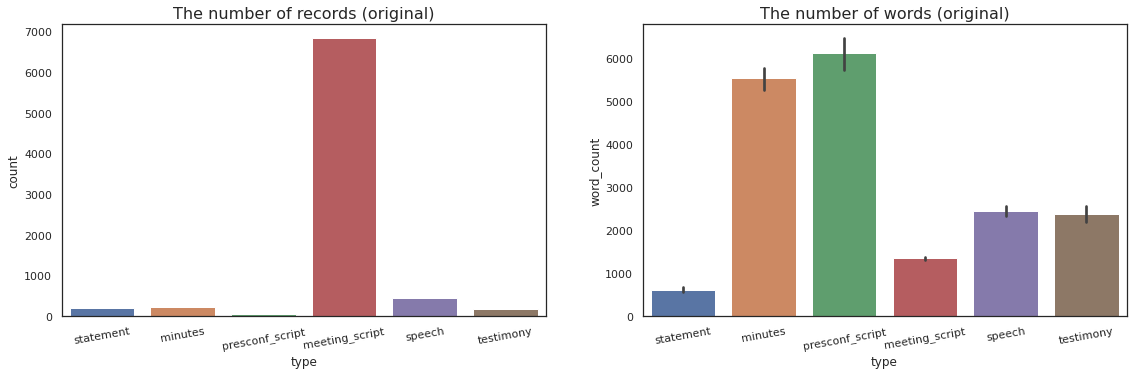

In [17]:
# All texts
plot_num_rec_word(text_no_split)
text_no_split.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,index
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,1,4.25,1994-07-06,0,4.25,"The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to sho...",NaN
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,1,5.5,1994-12-20,0,5.50,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.",NaN
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,-1,5.25,1996-03-26,0,5.25,"For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective im...",NaN
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,405,1,5.5,1997-05-20,0,5.50,"For immediate release\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage point to around 5-1/2 pe...",NaN
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,373,-1,5.25,1998-10-15,-1,5.00,"For immediate releaseThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1/...",NaN


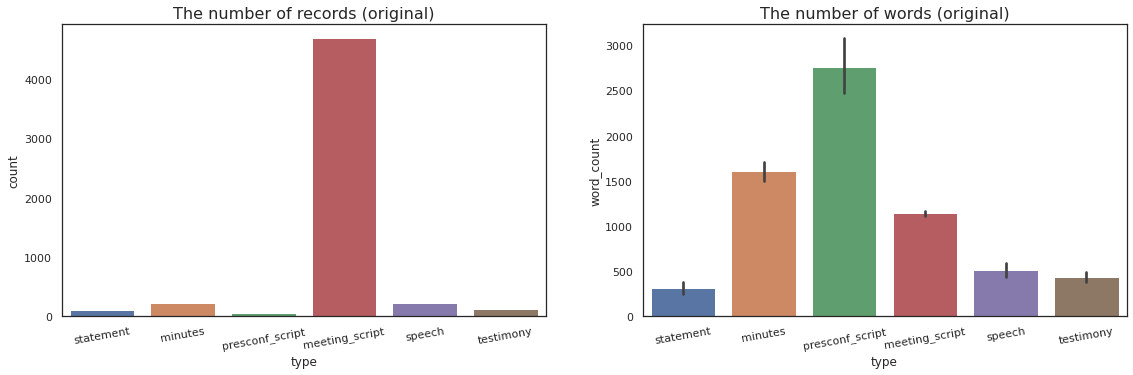

In [18]:
# Filtered by keywords
plot_num_rec_word(text_keyword)
text_keyword.head()

In [19]:
# # Drop meeting script data
# text_no_split = text_no_split.loc[text_no_split['type'] != 'meeting_script']
# text_split_200 = text_split_200.loc[text_split_200['type'] != 'meeting_script']
# text_keyword = text_keyword.loc[text_keyword['type'] != 'meeting_script']

### Select text dataframe

(1071, 11)



(1330, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou..."


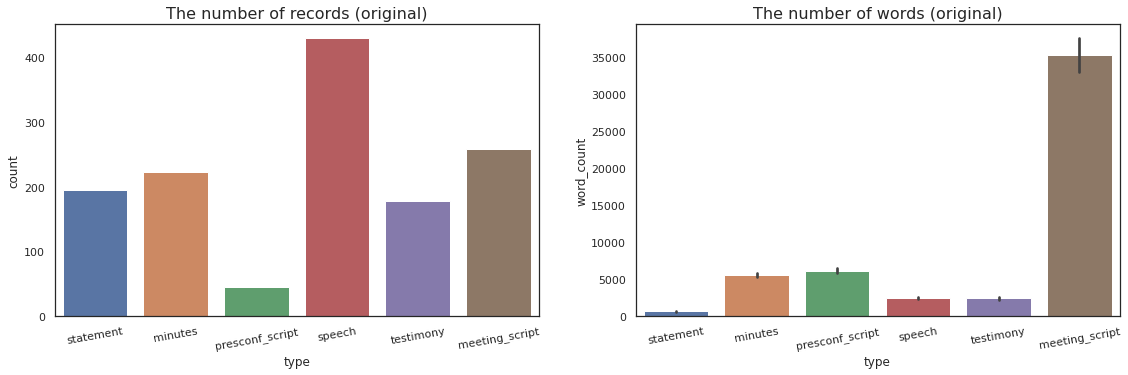

In [20]:
def combine_meeting_script(df):
    new_df = df.loc[df['type'] != 'meeting_script']
    print(new_df.shape)
    meeting_script_df = df.loc[df['type'] == 'meeting_script'].reset_index(drop=True)
    data_list = []
    for i, row in tqdm(meeting_script_df.iterrows(), total=meeting_script_df.shape[0]):
        if i == 0:
            prev_row = row
            continue
        if prev_row['date'].strftime('%Y-%m-%d') == row['date'].strftime('%Y-%m-%d'):
            prev_row['text'] = prev_row['text'] + row['text']
        else:
            prev_row['speaker'] = ""
            prev_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', prev_row['text']))
            data_list.append(list(prev_row))
            prev_row = row
            
    prev_row['speaker'] = ""
    prev_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', prev_row['text']))
    data_list.append(list(prev_row))
    new_meeting_script_df = pd.DataFrame(data_list, columns=df.columns)
    new_df = pd.concat([new_df, new_meeting_script_df], axis=0)
    print(new_df.shape)
    return new_df

train_df = combine_meeting_script(text_no_split)
plot_num_rec_word(train_df)
train_df.head()


### Inspect Data (Distribution)

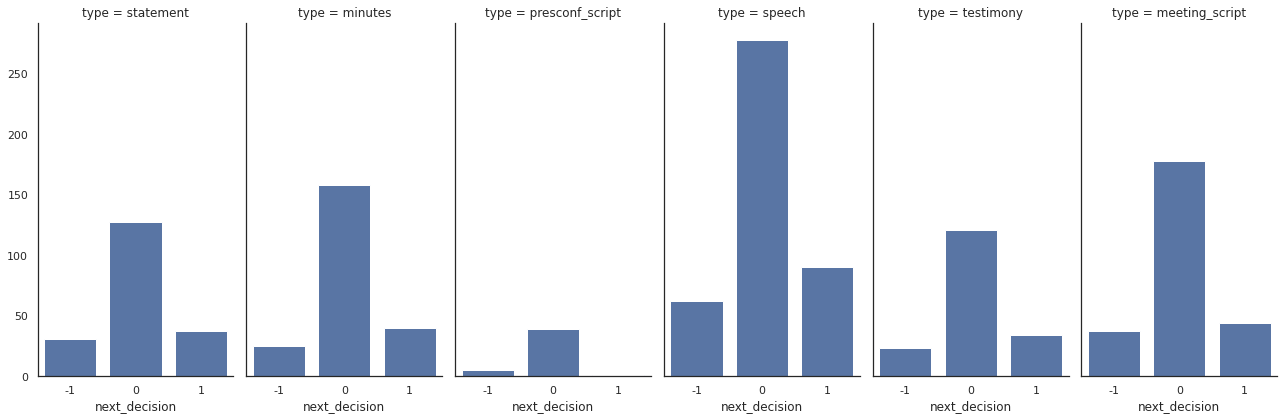

In [21]:
# Check balance of Rate Decision
g = sns.FacetGrid(train_df, col='type', height=6, aspect=0.5)
g.map(sns.countplot, 'next_decision')
plt.show()


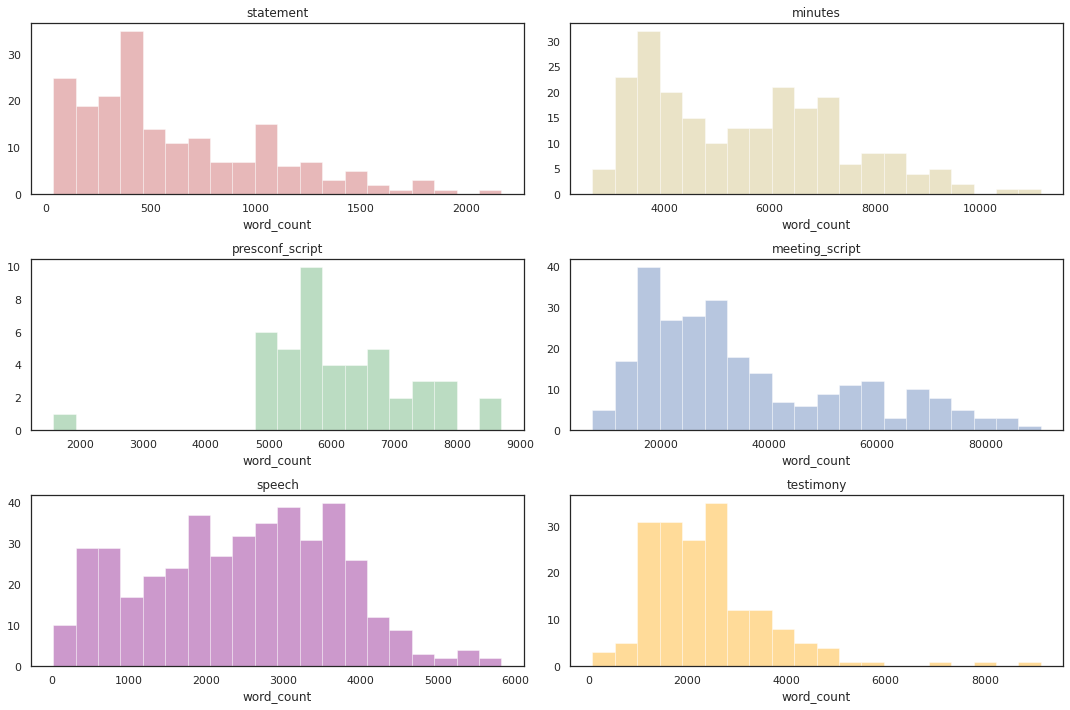

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
254,meeting_script,2014-06-18,FOMC Meeting Transcript,,81243,0,0,2014-07-30,0,0.00,"I’d like to begin by welcoming three people to the table today: StanFischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan andLael, but both have very deep experi..."
255,meeting_script,2014-07-30,FOMC Meeting Transcript,,83175,0,0,2014-09-17,0,0.00,"Good morning, everybody. I would like to begin today’s meeting bygiving the floor to President Fisher, who asked if he could take a minute to address the group.Thank you. Next I want to mention th..."
256,meeting_script,2014-09-17,FOMC Meeting Transcript,,57054,0,0,2014-10-29,1,0.00,"Good morning, everybody.Our first two items this morning will be conducted in a joint meeting between the FOMCand the Board. I need a motion to close the Board meeting.Thank you. Without objection..."
257,meeting_script,2014-10-29,FOMC Meeting Transcript,,68380,1,0,2014-12-17,0,0.00,"I’d like to call this meeting to order. Before turning to our agenda,I’d like to say a few words about our communications with the public. Many of you will recallthat in June 2011, the FOMC adopte..."
258,meeting_script,2014-12-17,FOMC Meeting Transcript,,55410,0,0,2016-01-27,0,0.25,"Good afternoon, everyone. I think we are ready to begin. The firstitem we are going to consider is in a joint Board and FOMC meeting, so I need a motion to closethe Board meeting.Without objection..."


<Figure size 1296x648 with 0 Axes>

In [22]:
plot_distribution(train_df, False)
train_df.tail()


### Add key

In [23]:
# Add a key for aggregation
train_df['key'] = train_df.index.get_level_values(0)
train_df.head()


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,0
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...,1
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,2
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...",3
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...",4


### Split Data

In [24]:
train_sent_df = split_df(train_df)
print(train_sent_df.shape)



(427850, 12)


### Check Distribution

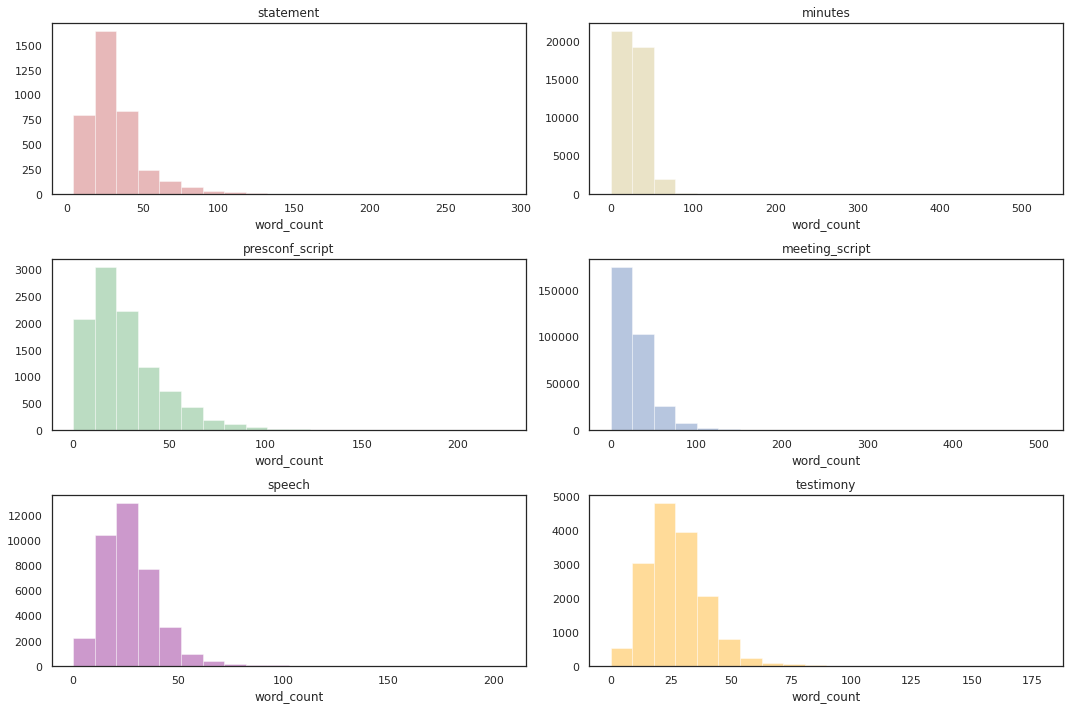

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key
427845,meeting_script,2014-12-17,FOMC Meeting Transcript,,15,0,0.0,2016-01-27,0,0.25,We need to make it very clear that we don’t have an inflation threshold.,258
427846,meeting_script,2014-12-17,FOMC Meeting Transcript,,62,0,0.0,2016-01-27,0,0.25,"Inother words, there’s not a requirement that inflation must be moving up at the time of liftoff.Instead, we just must expect that inflation will rise in the future back to our 2 percent objective...",258
427847,meeting_script,2014-12-17,FOMC Meeting Transcript,,30,0,0.0,2016-01-27,0,0.25,"I believe many market participants are confused about this, and that explains some ofthe difference between what we think we’re going to do and what market participants expect forthis.",258
427848,meeting_script,2014-12-17,FOMC Meeting Transcript,,12,0,0.0,2016-01-27,0,0.25,So I think we have to work on that a little bit.,258
427849,meeting_script,2014-12-17,FOMC Meeting Transcript,,4,0,0.0,2016-01-27,0,0.25,"Thank you, Madam Chair.",258


<Figure size 1296x648 with 0 Axes>

In [25]:
# Check distribution
plot_distribution(train_sent_df, False)
train_sent_df.tail()


### Index Adjustments

In [ ]:
# Reset index and set 'type' columns as index for faster processing
train_sent_df.reset_index
train_sent_df = train_sent_df.set_index('type', inplace=False)


In [46]:
# Inspect reindexed dataframe
train_sent_df


,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key
type,,,,,,,,,,,
statement,1994-02-04,FOMC Statement,Alan Greenspan,22,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions.,0
statement,1994-02-04,FOMC Statement,Alan Greenspan,18,1,3.25,1994-02-28,0,3.25,The action is expected to be associated with a small increase in short-term money market interest rates.,0
statement,1994-02-04,FOMC Statement,Alan Greenspan,23,1,3.25,1994-02-28,0,3.25,The decision was taken to move toward a less accommodative stance in monetary policy in order to sustain and enhance the economic expansion.,0
statement,1994-02-04,FOMC Statement,Alan Greenspan,36,1,3.25,1994-02-28,0,3.25,"Chairman Greenspan decided to announce this action immediately so as to avoid any misunderstanding of the Committee's purposes, given the fact that this is the first firming of reserve market cond...",0
statement,1994-03-22,FOMC Statement,Alan Greenspan,22,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions.,1
...,...,...,...,...,...,...,...,...,...,...,...
meeting_script,2014-12-17,FOMC Meeting Transcript,,15,0,0.00,2016-01-27,0,0.25,We need to make it very clear that we don’t have an inflation threshold.,258
meeting_script,2014-12-17,FOMC Meeting Transcript,,62,0,0.00,2016-01-27,0,0.25,"Inother words, there’s not a requirement that inflation must be moving up at the time of liftoff.Instead, we just must expect that inflation will rise in the future back to our 2 percent objective...",258
meeting_script,2014-12-17,FOMC Meeting Transcript,,30,0,0.00,2016-01-27,0,0.25,"I believe many market participants are confused about this, and that explains some ofthe difference between what we think we’re going to do and what market participants expect forthis.",258


## **Training Data**

### Notes

#### score_text

Inputs (and helpful metrics):
```
____________________________________________________________________________________________________________ 
|                   |           |                              |                                           |
|   Document Type   |   Sizes   |       Processing Times       |                  Comment                  |
|___________________|___________|______________________________|___________________________________________|
|    'statement'    |    3,804  |  Running Time = 00h:06m:50s  |   3804/3804 [06:50<00:00, 9.27it/s]       |
|     'minutes'     |   42,807  |  Running Time = 01h:36m:37s  |   42807/42807 [1:36:37<00:00, 7.38it/s]   |
| 'presconf_script' |   10,160  |  Running Time = 00h:18m:21s  |   10160/10160 [18:21<00:00, 9.22it/s]     |
|     'speech'      |   38,461  |  Running Time = 01h:07m:39s  |   38461/38461 [1:07:39<00:00, 9.47it/s]   |
|    'testimony'    |   15,687  |  Running Time = 00h:26m:57s  |   15687/15687 [26:57<00:00, 9.70it/s]     |
|  'meeting_script' |  316,931  |  Running Time = 01h:07m:39s  |   316931/316931 [26:57<00:00, 9.70it/s]   |
|___________________|___________|______________________________|___________________________________________|
```

Outputs:
```
result_df (all processed datasets and prediction scores)
```

### Data: Split by Sentence

#### Load Data

In [99]:
# Load and make copies of data (Split by sentence)
train_sent_df_copy = train_sent_df
train_sent_df_copy_2 = train_sent_df
train_sent_df_copy_3 = train_sent_df
train_sent_df_copy_4 = train_sent_df
train_sent_df_copy_5 = train_sent_df
train_sent_df


,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key
type,,,,,,,,,,,
statement,1994-02-04,FOMC Statement,Alan Greenspan,22,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions.,0
statement,1994-02-04,FOMC Statement,Alan Greenspan,18,1,3.25,1994-02-28,0,3.25,The action is expected to be associated with a small increase in short-term money market interest rates.,0
statement,1994-02-04,FOMC Statement,Alan Greenspan,23,1,3.25,1994-02-28,0,3.25,The decision was taken to move toward a less accommodative stance in monetary policy in order to sustain and enhance the economic expansion.,0
statement,1994-02-04,FOMC Statement,Alan Greenspan,36,1,3.25,1994-02-28,0,3.25,"Chairman Greenspan decided to announce this action immediately so as to avoid any misunderstanding of the Committee's purposes, given the fact that this is the first firming of reserve market cond...",0
statement,1994-03-22,FOMC Statement,Alan Greenspan,22,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions.,1
...,...,...,...,...,...,...,...,...,...,...,...
meeting_script,2014-12-17,FOMC Meeting Transcript,,15,0,0.00,2016-01-27,0,0.25,We need to make it very clear that we don’t have an inflation threshold.,258
meeting_script,2014-12-17,FOMC Meeting Transcript,,62,0,0.00,2016-01-27,0,0.25,"Inother words, there’s not a requirement that inflation must be moving up at the time of liftoff.Instead, we just must expect that inflation will rise in the future back to our 2 percent objective...",258
meeting_script,2014-12-17,FOMC Meeting Transcript,,30,0,0.00,2016-01-27,0,0.25,"I believe many market participants are confused about this, and that explains some ofthe difference between what we think we’re going to do and what market participants expect forthis.",258


#### Slice Data by Type
*This is done with performance considerations in mind. When the score_text definition is optimized, this step will not necessary.*

In [101]:
# Extract document types:
doc_types = train_sent_df.index.unique()
doc_types = pd.DataFrame(doc_types)
doc_types['type']

0          statement
1            minutes
2    presconf_script
3             speech
4          testimony
5     meeting_script
Name: type, dtype: object

In [102]:
result_df_statement = train_sent_df.loc['statement']
result_df_minutes = train_sent_df.loc['minutes']
result_df_presconf_script = train_sent_df.loc['presconf_script']
result_df_speech = train_sent_df.loc['speech']
result_df_testimony = train_sent_df.loc['testimony']
result_df_meeting_script = train_sent_df.loc['meeting_script']


#### Inspect Data

In [ ]:
# Statement Data
result_df_statement


In [ ]:
# Minute Data
result_df_minutes


In [ ]:
# Press Conference Script Data
result_df_presconf_script


In [ ]:
# Speech Data
result_df_speech


In [ ]:
# Testimony Data
result_df_testimony


In [ ]:
# Meeting Script Data
result_df_meeting_script


#### Compute Text Scores

In [129]:
# Score Statement Text
print('Processing {}...'.format('statement'))
res_statement = score_text(result_df_statement, 'text', model)


Processing statement...


In [132]:
# View/Save result
save_data(res_statement, 'res_statement')
res_statement


Successfully saved res_statement.pickle. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/res_statement.pickle
Successfully saved res_statement.csv. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/res_statement.csv


,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key,score,prediction
type,,,,,,,,,,,,,
statement,1994-02-04,FOMC Statement,Alan Greenspan,22,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions.,0,"[0.265679, 0.4292045, 0.3051165]",Neutral
statement,1994-02-04,FOMC Statement,Alan Greenspan,18,1,3.25,1994-02-28,0,3.25,The action is expected to be associated with a small increase in short-term money market interest rates.,0,"[0.38790688, 0.28445256, 0.32764056]",Negative
statement,1994-02-04,FOMC Statement,Alan Greenspan,23,1,3.25,1994-02-28,0,3.25,The decision was taken to move toward a less accommodative stance in monetary policy in order to sustain and enhance the economic expansion.,0,"[0.2920675, 0.38669592, 0.32123658]",Neutral
statement,1994-02-04,FOMC Statement,Alan Greenspan,36,1,3.25,1994-02-28,0,3.25,"Chairman Greenspan decided to announce this action immediately so as to avoid any misunderstanding of the Committee's purposes, given the fact that this is the first firming of reserve market cond...",0,"[0.28042954, 0.3974015, 0.32216892]",Neutral
statement,1994-03-22,FOMC Statement,Alan Greenspan,22,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions.,1,"[0.265679, 0.4292045, 0.3051165]",Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
statement,2008-11-25,FOMC statement,Ben Bernanke,36,-1,0.00,2008-12-16,-1,0.00,"This action is being taken to reduce the cost and increase the availability of credit for the purchase of houses, which in turn should support housing markets and foster improved conditions in fin...",194,"[0.30154294, 0.38094538, 0.31751165]",Neutral
statement,2008-11-25,FOMC statement,Ben Bernanke,32,-1,0.00,2008-12-16,-1,0.00,Purchases of up to $100 billion in GSE direct obligations under the program will be conducted with the Federal Reserve's primary dealers through a series of competitive auctions and will begin nex...,194,"[0.2772094, 0.39815027, 0.32464033]",Neutral
statement,2008-11-25,FOMC statement,Ben Bernanke,28,-1,0.00,2008-12-16,-1,0.00,Purchases of up to $500 billion in MBS will be conducted by asset managers selected via a competitive process with a goal of beginning these purchases before year-end.,194,"[0.29434365, 0.36584723, 0.33980912]",Neutral


In [ ]:
# Score Minutes Text
print('Processing {}...'.format('minutes'))
res_minutes = score_text(result_df_minutes, 'text', model)


In [ ]:
# View/Save result
save_data(res_minutes, 'res_minutes')
res_minutes


In [134]:
# Score Press Conference Script Text
print('Processing {}...'.format('presconf_script'))
res_presconf_script = score_text(result_df_presconf_script, 'text', model)


Processing presconf_script...


In [135]:
# View/Save result
save_data(res_presconf_script, 'res_presconf_script')
res_presconf_script


Successfully saved res_presconf_script.pickle. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/res_presconf_script.pickle
Successfully saved res_presconf_script.csv. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/res_presconf_script.csv


,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key,score,prediction
type,,,,,,,,,,,,,
presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,2,0,0.0,2011-06-22,0,0.0,Good afternoon.,418,"[0.25853837, 0.43621957, 0.30524203]",Neutral
presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,16,0,0.0,2011-06-22,0,0.0,"Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision.",418,"[0.28399488, 0.37705594, 0.3389491]",Neutral
presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,45,0,0.0,2011-06-22,0,0.0,"I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections also beingreleased today, and I’ll place today’s policy decision in the context of the Committee’sprojectio...",418,"[0.321426, 0.31113642, 0.36743754]",Positive
presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,9,0,0.0,2011-06-22,0,0.0,I’ll then be glad to take your questions.,418,"[0.2832653, 0.38631406, 0.33042067]",Neutral
presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,23,0,0.0,2011-06-22,0,0.0,"Throughout today’s briefing, my goalwill be to reflect the consensus of the Committee, while taking note of the diversity of views asappropriate.",418,"[0.26594195, 0.37598217, 0.3580759]",Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
presconf_script,2020-12-16,FOMC Press Conference Transcript,Jerome Powell,38,0,NaN,2021-01-27,0,NaN,"December 16, 2020Chair Powell’s Press ConferenceFINALYeah, I mean, that’s—I think we’re a very, very long way from that.You know, the, the Congress has given the Fed independence on the condition ...",462,"[0.32684484, 0.35643923, 0.31671593]",Neutral
presconf_script,2020-12-16,FOMC Press Conference Transcript,Jerome Powell,7,0,NaN,2021-01-27,0,NaN,We try very hard to do that.,462,"[0.2781422, 0.40354353, 0.31831422]",Neutral
presconf_script,2020-12-16,FOMC Press Conference Transcript,Jerome Powell,12,0,NaN,2021-01-27,0,NaN,"And I, I think that’s, that’s what people call fiscaldominance.",462,"[0.3030271, 0.36558118, 0.33139172]",Neutral


In [ ]:
# Score Speech Text
print('Processing {}...'.format('speech'))
res_speech = score_text(result_df_speech, 'text', model)


In [ ]:
# View/Save result
save_data(res_speech, 'res_speech')
res_speech


In [ ]:
# Score Testimony Text
print('Processing {}...'.format('testimony'))
res_testimony = score_text(result_df_testimony, 'text', model)


Processing testimony...


In [ ]:
# View/Save result
save_data(res_testimony, 'res_testimony')
res_testimony


In [ ]:
# Score Meeting Script Text
print('Processing {}...'.format('meeting_script'))
res_meeting_script = score_text(result_df_meeting_script, 'text', model)


In [ ]:
# View/Save result
save_data(res_meeting_script, 'res_meeting_script')
res_meeting_script


#### Combine Data

In [ ]:
# Initialize empty dataframe
result_df = pd.DataFrame([], columns=train_sent_df.columns)
result_df


In [ ]:
# Merge statement score data
result_df = pd.concat([result_df, res_statement], axis=0)


In [ ]:
# Merge minutes score data
result_df = pd.concat([result_df, res_minutes], axis=0)


In [ ]:
# Merge press conference script score data
result_df = pd.concat([result_df, res_presconf_script], axis=0)


In [ ]:
# Merge speech score data
result_df = pd.concat([result_df, res_speech], axis=0)


In [ ]:
# Merge testimony score data
result_df = pd.concat([result_df, res_testimony], axis=0)


In [ ]:
# Merge meeting script score data
result_df = pd.concat([result_df, res_meeting_script], axis=0)


In [ ]:
# Convert categorical variables into dummy/indicator variables.
result_df = pd.concat([result_df, pd.get_dummies(result_df['prediction'])], axis=1)
result_df.head()


#### Inspect Data

In [ ]:
# Inspect prediction dataset
result_df


In [ ]:
# Sentiment overview
train_result = train_df.copy()
train_result['key2'] = train_result['type'] + "_" + train_result['key'].map(str)
result_df['key2'] = result_df['type'] + "_" + result_df['key'].map(str)

neg = result_df.groupby(by=['key2'])['Negative'].sum()
neu = result_df.groupby(by=['key2'])['Neutral'].sum()
pos = result_df.groupby(by=['key2'])['Positive'].sum()

train_result = train_result.merge(neg, on='key2', how='left')
train_result = train_result.merge(neu, on='key2', how='left')
train_result = train_result.merge(pos, on='key2', how='left')

train_result['sentiment'] = (train_result['Positive'] - train_result['Negative'])
train_result.sort_values(['type', 'next_meeting'], inplace=True)

print("The number of records: ", train_result.shape[0])
print("Sentiment is null: ", train_result['sentiment'].isnull().sum())
train_result.tail()


In [ ]:
# Extract document types
stmt_df = get_doctype_df(train_result, 'statement')
minutes_df = get_doctype_df(train_result, 'minutes')
presconf_df = get_doctype_df(train_result, 'presconf_script')
m_script_df = get_doctype_df(train_result, 'meeting_script')
speech_df = get_doctype_df(train_result, 'speech')
testimony_df = get_doctype_df(train_result, 'testimony')
all_df = get_doctype_df(pd.concat([stmt_df, minutes_df, presconf_df, m_script_df, speech_df, testimony_df], axis=0), 'all')

all_df


In [ ]:
# Sentiment Plot (All Types)
plot_sentiment(all_df, 'All', 'sentiment')


In [ ]:
# Sentiment Plot (Statements)
plot_sentiment(stmt_df, 'Statement', 'sentiment')


In [ ]:
# Sentiment Plot (Minutes)
plot_sentiment(minutes_df, 'Minutes', 'sentiment')


In [ ]:
# Sentiment Plot (Press Conference Scripts)
plot_sentiment(presconf_df, 'Press Conference Script', 'sentiment')


In [ ]:
# Sentiment Plot (Meeting Scripts)
plot_sentiment(m_script_df, 'Meeting Script', 'sentiment')


In [ ]:
# Sentiment Plot (Speeches)
plot_sentiment(speech_df, 'Speech', 'sentiment')


In [ ]:
# Sentiment Plot (Testimonies)
plot_sentiment(testimony_df, 'Testimony', 'sentiment')


#### Save Data

In [ ]:
# Save BERT data
save_data(result_df, 'sentiment_bert_result')
save_data(all_df, 'sentiment_bert_all')
save_data(stmt_df, 'sentiment_bert_stmt')
save_data(minutes_df, 'sentiment_bert_minutes')
save_data(presconf_df, 'sentiment_bert_presconf')
save_data(m_script_df, 'sentiment_bert_m_script')
save_data(speech_df, 'sentiment_bert_speech')
save_data(testimony_df, 'sentiment_bert_testimony')


### Data: No Split

#### Load Data

In [ ]:
# Load data (No split)
file = open(train_dir + 'train_df.pickle', 'rb')
train_df = pickle.load(file)
file.close()
print(train_df.shape)
train_df


#### Drop Columns

In [92]:
train_df.drop(columns=['statement', 
                       'minutes', 
                       'presconf_script', 
                       'speech', 
                       'testimony', 
                       'text', 
                       'tokenized', 
                       'token_ids', 
                       'tokenized_text', 
                       'tfidf_Negative', 
                       'tfidf_Positive', 
                       'tfidf_Uncertainty', 
                       'tfidf_Litigious', 
                       'tfidf_StrongModal', 
                       'tfidf_Constraining'
                       ],
              inplace=True)

train_df.drop(columns=['tone','cos_sim_Negative', 
                       'cos_sim_Positive', 
                       'cos_sim_Uncertainty', 
                       'cos_sim_Litigious', 
                       'cos_sim_StrongModal', 
                       'cos_sim_Constraining'
                       ], 
              inplace=True)


#### Change Inputs

In [93]:
# Use Statement Score and Minutes Score (Sentiment count, net score and change from the previous meeting) as inputs
train_df = train_df.merge(stmt_df[['Negative', 'Neutral', 'Positive', 'sentiment', 'sentiment_chg']], left_index=True, right_index=True, how='left')
train_df = train_df.merge(minutes_df[['Negative', 'Neutral', 'Positive', 'sentiment', 'sentiment_chg']], left_index=True, right_index=True, how='left', suffixes=('_stmt', '_minutes'))
train_df


NameError: ignored

## **Test Model**

### Check Imputation

In [ ]:
# Check the imputation
data = train_df.values
Xtmp, y1 = np.array(data[:, 1:], dtype=np.float64), np.array(data[:, 0], dtype=np.int64)+1
print('The number of training data: %d' % len(Xtmp))
print('Missing: %d' % sum(np.isnan(Xtmp).flatten()))
imputer = SimpleImputer(strategy='mean')
imputer.fit(Xtmp)
X1 = imputer.transform(Xtmp)
print('\nImputed:')
print('The number of training data: %d' % len(X1))
print('Missing: %d' % sum(np.isnan(X1).flatten()))

data2 = train_df.dropna().values
X2, y2 = np.array(data2[:, 1:], dtype=np.float64), np.array(data2[:, 0], dtype=np.int64)+1
print('\nDropped:')
print('The number of training data: %d' % len(X2))
print('Missing: %d' % sum(np.isnan(X2).flatten()))


### Check Pipeline

In [69]:
# Check the pipeline with imputation
model = RandomForestClassifier()
imputer = SimpleImputer(strategy='mean')
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Random Forest
scores = cross_val_score(pipeline, Xtmp, y1, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
scores = cross_val_score(pipeline, Xtmp, y1, scoring='f1_macro', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


NameError: ignored

### Test Classifiers

In [ ]:
random_state = 42
#kfold = StratifiedKFold(n_splits=10, random_state=random_state)
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
imputer = SimpleImputer(strategy='mean')
classifiers = []
classifiers.append(("SVC", SVC(random_state=random_state)))
classifiers.append(("DecisionTree", DecisionTreeClassifier(random_state=random_state)))
classifiers.append(("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)))
classifiers.append(("RandomForest", RandomForestClassifier(random_state=random_state)))
classifiers.append(("ExtraTrees", ExtraTreesClassifier(random_state=random_state)))
classifiers.append(("GradientBoosting", GradientBoostingClassifier(random_state=random_state)))
classifiers.append(("MultipleLayerPerceptron", MLPClassifier(random_state=random_state)))
classifiers.append(("KNeighboors", KNeighborsClassifier(n_neighbors=3)))
classifiers.append(("LogisticRegression", LogisticRegression(random_state = random_state)))
classifiers.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()))
classifiers.append(("GaussianNB", GaussianNB()))
classifiers.append(("Perceptron", Perceptron()))
classifiers.append(("LinearSVC", LinearSVC()))
classifiers.append(("SGD", SGDClassifier()))

cv_results = []
classifier_name = []
for classifier in classifiers :
    cv_results.append(cross_validate(classifier[1], X1, y1, scoring=["accuracy", "f1_macro"], cv=kfold, n_jobs=-1))
    classifier_name.append(classifier[0])

cv_acc_means = []
cv_acc_std = []
cv_f1_means = []
cv_f1_std = []
for cv_result in cv_results:
    cv_acc_means.append(cv_result['test_accuracy'].mean())
    cv_acc_std.append(cv_result['test_accuracy'].std())
    cv_f1_means.append(cv_result['test_f1_macro'].mean())
    cv_f1_std.append(cv_result['test_f1_macro'].std())

cv_res = pd.DataFrame({"Algorithm": classifier_name,
                       "CVAccMeans":cv_acc_means,
                       "CVAccErrors": cv_acc_std,
                       "CVf1Means":cv_f1_means,
                       "CVf1Errors": cv_f1_std}).sort_values(by='CVAccMeans', ascending=False)

cv_res


In [ ]:
fig, ax = plt.subplots(figsize=(17,10))
tidy = cv_res[['Algorithm', 'CVAccMeans', 'CVf1Means']].melt(id_vars='Algorithm').rename(columns=str.title)
sns.barplot(x='Algorithm', y='Value', hue='Variable', data=tidy, ax=ax, **{'yerr':[cv_acc_std, cv_f1_std]})
sns.despine(fig)
ax.set_xlabel("Algorithm", size=14)
ax.set_ylabel("Score", size=14)
#ax.legend(['Accuracy', 'F1 Score'])
ax.set_title("Cross validation scores", size=16)
for item in ax.get_xticklabels():
    item.set_rotation(25)


## **Training Pipeline**

### Model Definition

In [ ]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


### Accuracy Metrics

In [ ]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'


### Test/Train Data

In [ ]:
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X1, y1, test_size=0.2, shuffle=True)


### Classifier Definitions

In [ ]:
# Define Classifier
DTC = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(DTC, random_state=rand_seed)

#Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 100, 20, dtype=int),
              'base_estimator__criterion': ['gini'],
              'base_estimator__splitter': ['random'],
              'algorithm': ['SAMME'],
              'learning_rate': [0.0001]}

ada_model = train_grid_search(ada_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ada_best = ada_model.best_estimator_


In [ ]:
# Define Classifier
DTC = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(DTC, random_state=rand_seed)
#ExtraTrees 
ext_clf = ExtraTreesClassifier()
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 200, 10, dtype=int),
              'min_samples_split': [4],
              'min_samples_leaf': [8],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

ext_model = train_grid_search(ext_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ext_best = ext_model.best_estimator_


In [ ]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 10, dtype=int),
              'min_samples_split': [8],
              'min_samples_leaf': [8],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_


In [ ]:
# Gradient boosting
gb_clf = GradientBoostingClassifier(random_state=2)

# Perform Grid Search
param_grid = {'n_estimators': [1, 20, 50, 80, 130, 200, 300, 400],
              'min_samples_leaf': [16],
              'max_features': [0.8],
              'max_depth': [4],
              'loss': ['deviance'],
              'learning_rate': [0.05]}

gb_model = train_grid_search(gb_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
gb_best = gb_model.best_estimator_


In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best), 
                     ("ExtraTrees", ext_best), 
                     ("RandomForest", rf_best), 
                     ("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=train_df.columns[indices][:40], x=classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1


In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best), 
                     ("ExtraTrees", ext_best), 
                     ("RandomForest", rf_best), 
                     ("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=train_df.columns[indices][:40], x=classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1


In [ ]:
test_ada = pd.Series(ada_best.predict(X_test), name="Ada")
test_ext = pd.Series(ext_best.predict(X_test), name="ExtC")
test_rf = pd.Series(rf_best.predict(X_test), name="RFC")
test_gb = pd.Series(gb_best.predict(X_test), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_ada, test_ext, test_rf, test_gb],axis=1)

g = sns.heatmap(ensemble_results.corr(),annot=True, cmap="coolwarm", center=0.7)


In [ ]:
# The same including all the other classifiers
test_resuts = []

for classifier in classifiers:
    estimator = classifier[1].fit(X_train, Y_train)
    test_resuts.append(pd.Series(estimator.predict(X_test), name=classifier[0]))

base_results = pd.concat(test_resuts, axis=1)

plt.figure(figsize=(20,10))
g = sns.heatmap(base_results.corr(),annot=True, cmap="coolwarm", center=0.7)


In [ ]:
# Voting Classifier with "soft" to take all the probability into account
voting_best = VotingClassifier(estimators=[('adac', ada_best),
                                           ('extc', ext_best), 
                                           ('rfc', rf_best), 
                                           ('gbc', gb_best)], voting='soft', n_jobs=-1)

# # Voting Classifier with "soft" to take all the probability into account
# voting_base = VotingClassifier(estimators=classifiers, voting='soft', n_jobs=4)

voting_best.fit(X_train, Y_train)


## **Prediction Pipeline**

### Test Grid Search

#### Perform Prediction

In [ ]:
# Predict
voting_pred_train = voting_best.predict(X_train)
voting_pred_test = voting_best.predict(X_test)


#### Compute Accuracy

In [ ]:
acc, f1 = metric(Y_train, voting_pred_train)
logger.info('Train - acc: %.8f, f1: %.8f' % (acc, f1))

acc, f1 = metric(Y_test, voting_pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))


### XGBoost

#### Configure Data

In [ ]:
X_test_s = pd.DataFrame(X_test)
X_test_stacked = pd.concat([X_test_s, X_test_s, X_test_s, X_test_s], axis=0)
pred_test_stacked = pd.concat([test_ada, test_ext, test_rf, test_gb],axis=0)


#### Configure Classifier

In [ ]:
gbm = xgb.XGBClassifier(
    n_estimator=2000,
    max_depth=4,
    min_child_weight=2,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1).fit(X_test_stacked, pred_test_stacked)


#### Predict

In [ ]:
# Predict
gbm_pred_train = gbm.predict(pd.DataFrame(X_train))
gbm_pred_test = gbm.predict(X_test_s)

acc, f1 = metric(Y_train, gbm_pred_train)
logger.info('Train - acc: %.8f, f1: %.8f' % (acc, f1))

acc, f1 = metric(Y_test, gbm_pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
